<a href="https://colab.research.google.com/github/mirza019/Temporal_Clustering_in_Dynamic_Medical_Datasets/blob/main/Temporal_Clustering_in_Dynamic_Medical_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Install libraries (if needed)
!pip install -q scikit-learn pandas matplotlib seaborn


In [2]:
# STEP 2: Reload and include more subjects by allowing at least 3 non-NaN values per biomarker
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import seaborn as sns



In [3]:


# STEP 3: Upload CSV
from google.colab import files
uploaded = files.upload()

# Load the dataset (rename as needed)
df_long = pd.read_csv("oasis_longitudinal.csv")


Saving oasis_longitudinal.csv to oasis_longitudinal (1).csv


In [4]:

# Select columns of interest
biomarkers = ['MMSE', 'CDR', 'eTIV', 'nWBV']
df_biomarkers = df_long[['Subject ID', 'Visit'] + biomarkers].dropna(subset=['Subject ID', 'Visit'])

# Create pivot tables per biomarker with at least 3 time points
subject_series = {}
for biomarker in biomarkers:
    pivot = df_biomarkers.pivot(index='Subject ID', columns='Visit', values=biomarker)
    pivot = pivot.loc[pivot.notna().sum(axis=1) >= 3]  # At least 3 visits
    pivot = pivot.interpolate(axis=1, limit_direction='both')  # Fill missing via interpolation
    subject_series[biomarker] = pivot


In [5]:

# Get common subjects with enough data for all biomarkers
common_subjects = set.intersection(*[set(df.index) for df in subject_series.values()])
combined = []

for subject in sorted(common_subjects):
    row = []
    for biomarker in biomarkers:
        row.extend(subject_series[biomarker].loc[subject].values.tolist())
    combined.append(row)


In [6]:

# Create feature matrix
df_combined = pd.DataFrame(combined, index=sorted(common_subjects))
df_combined.columns = [f"{b}_v{v+1}" for b in biomarkers for v in range(subject_series[biomarkers[0]].shape[1])]
df_combined = df_combined.dropna()

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)


In [7]:

# Store silhouette scores
scores = []
k_values = range(2, 7)  # silhouette_score requires at least 2 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
        scores.append((k, score))
        print(f"k = {k}, Silhouette Score = {score:.2f}")
    else:
        scores.append((k, None))
        print(f"k = {k}, Invalid clustering (only one cluster assigned)")

# Identify the best k
best_k, best_score = max((item for item in scores if item[1] is not None), key=lambda x: x[1])
best_k, best_score



k = 2, Silhouette Score = 0.33
k = 3, Silhouette Score = 0.27
k = 4, Silhouette Score = 0.32
k = 5, Silhouette Score = 0.25
k = 6, Silhouette Score = 0.25


(2, np.float64(0.32874996581017546))

In [8]:

# Cluster
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_combined['Cluster'] = labels

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [9]:

# STEP 9: Evaluate with Silhouette Score
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.2f}")


Silhouette Score: 0.32


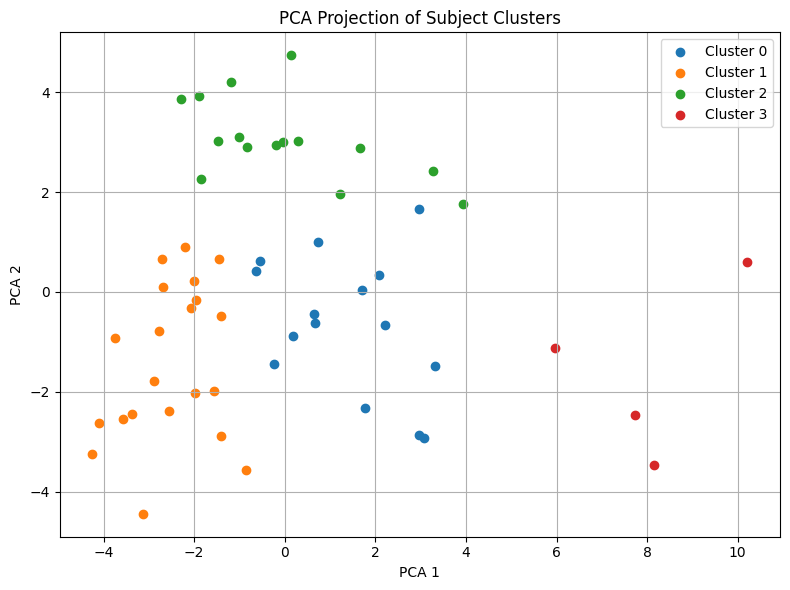

Silhouette Score: 0.32


55

In [10]:

# Plot PCA projection
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}')
plt.title("PCA Projection of Subject Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette Score
if len(np.unique(labels)) > 1 and len(labels) > len(np.unique(labels)):
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.2f}")
else:
    print(f"Silhouette score not valid: only {len(np.unique(labels))} unique cluster(s) for {len(labels)} samples.")

# Show updated sample size
df_combined.shape[0]


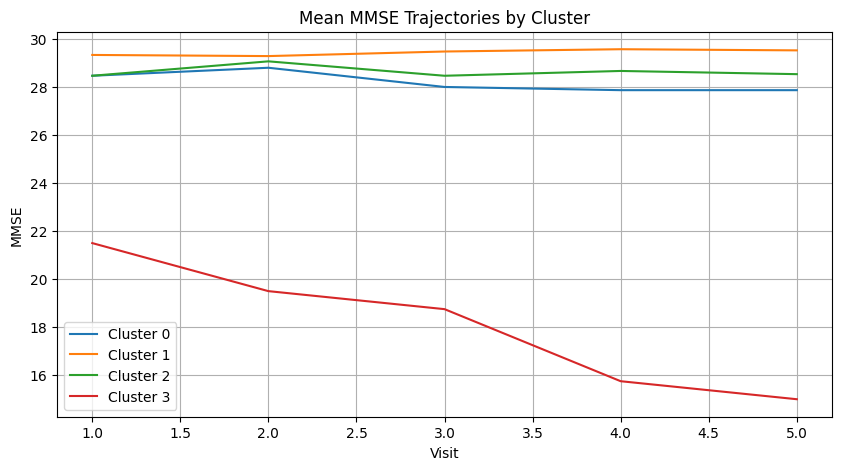

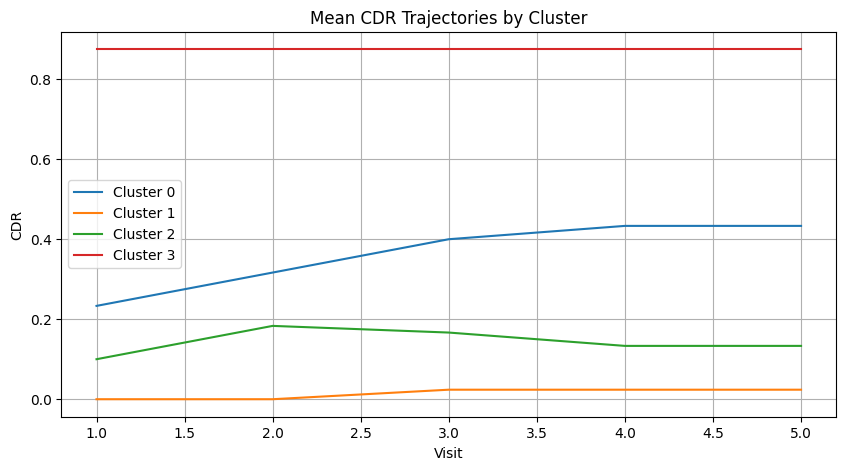

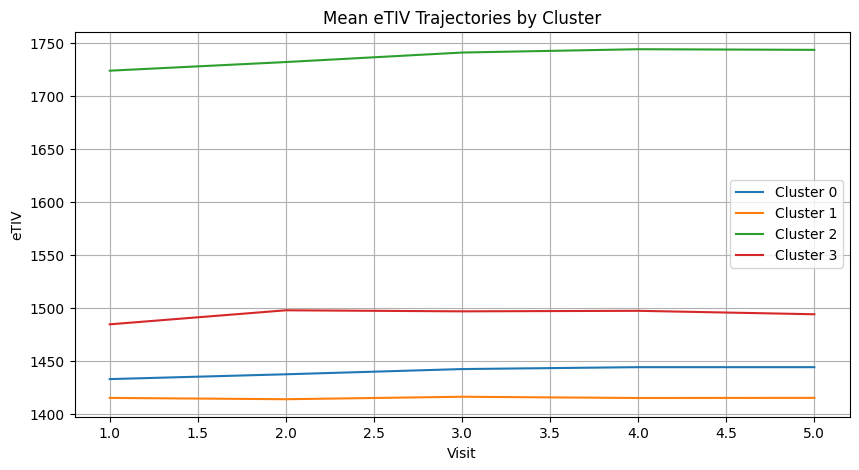

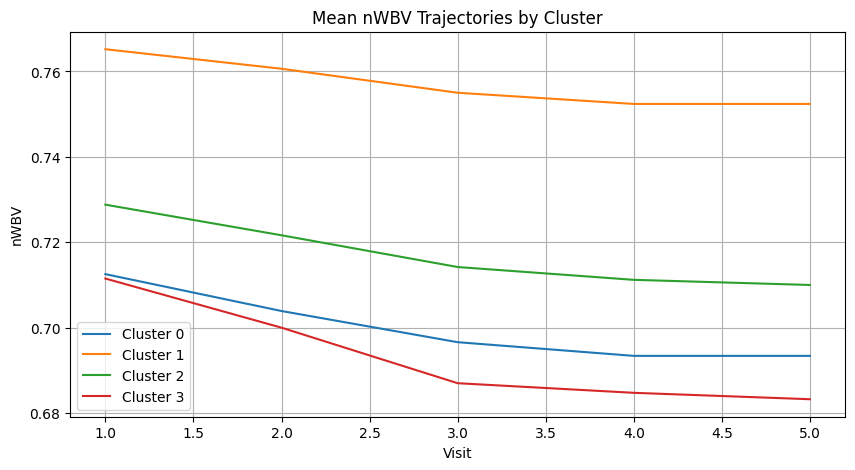

In [11]:

# STEP 10: Plot biomarker trajectories
def plot_cluster_trajectories(biomarker_name):
    df_traj = subject_series[biomarker_name].loc[df_combined.index]
    df_traj['Cluster'] = df_combined['Cluster']
    cluster_means = df_traj.groupby('Cluster').mean().T

    plt.figure(figsize=(10, 5))
    for cluster in cluster_means.columns:
        plt.plot(cluster_means.index, cluster_means[cluster], label=f'Cluster {cluster}')
    plt.title(f"Mean {biomarker_name} Trajectories by Cluster")
    plt.xlabel("Visit")
    plt.ylabel(biomarker_name)
    plt.grid(True)
    plt.legend()
    plt.show()

for biomarker in biomarkers:
    plot_cluster_trajectories(biomarker)

In [12]:
# STEP: Add Alzheimer detection based on CDR score
# CDR values: 0 = Normal, 0.5 = MCI, 1+ = Demented

# Reload full biomarker data including CDR to label
cdr_df = subject_series['CDR'].loc[df_combined.index].copy()

# Use most recent visit CDR for diagnosis (last column)
cdr_last = cdr_df.iloc[:, -1]

# Define Alzheimer's diagnosis label
# 0 = Normal (CDR = 0), 1 = Alzheimer's/MCI (CDR >= 0.5)
alzheimers_label = (cdr_last >= 0.5).astype(int)

# Add label to dataframe
df_combined['Alzheimers_Label'] = alzheimers_label



In [13]:


# Use PCA-reduced features for prediction
X_features = X_pca
y_labels = alzheimers_label

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]



In [14]:
# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_prob)

(conf_matrix, class_report, roc_auc)


(array([[12,  1],
        [ 0,  4]]),
 {'0': {'precision': 1.0,
   'recall': 0.9230769230769231,
   'f1-score': 0.96,
   'support': 13.0},
  '1': {'precision': 0.8,
   'recall': 1.0,
   'f1-score': 0.8888888888888888,
   'support': 4.0},
  'accuracy': 0.9411764705882353,
  'macro avg': {'precision': 0.9,
   'recall': 0.9615384615384616,
   'f1-score': 0.9244444444444444,
   'support': 17.0},
  'weighted avg': {'precision': 0.9529411764705882,
   'recall': 0.9411764705882353,
   'f1-score': 0.9432679738562091,
   'support': 17.0}},
 np.float64(1.0))

In [15]:
# Re-run the Alzheimer's detection classification block for evaluation

# Extract latest CDR values and define labels
cdr_last = subject_series['CDR'].loc[df_combined.index].iloc[:, -1]
df_combined['Alzheimers_Label'] = (cdr_last >= 0.5).astype(int)

# Train-test split using PCA-transformed features
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_combined['Alzheimers_Label'], test_size=0.3, random_state=42)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)



LogisticRegression()

In [16]:

# Predict and calculate metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Output evaluation results
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

(conf_matrix, class_report, roc_auc)

(array([[12,  1],
        [ 0,  4]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.92      0.96        13\n           1       0.80      1.00      0.89         4\n\n    accuracy                           0.94        17\n   macro avg       0.90      0.96      0.92        17\nweighted avg       0.95      0.94      0.94        17\n',
 np.float64(1.0))

In [17]:


# Define SVM model (with probability=True so we can use predict_proba)
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated probability predictions
y_cv_prob = cross_val_predict(
    svm_model,
    X_pca,   # your PCA-transformed features
    df_combined["Alzheimers_Label"],
    cv=cv,
    method="predict_proba"
)[:, 1]

# Binary predictions at threshold 0.5
y_cv_pred = (y_cv_prob >= 0.5).astype(int)

# ROC & AUC
fpr_cv, tpr_cv, _ = roc_curve(df_combined["Alzheimers_Label"], y_cv_prob)
roc_auc_cv = auc(fpr_cv, tpr_cv)


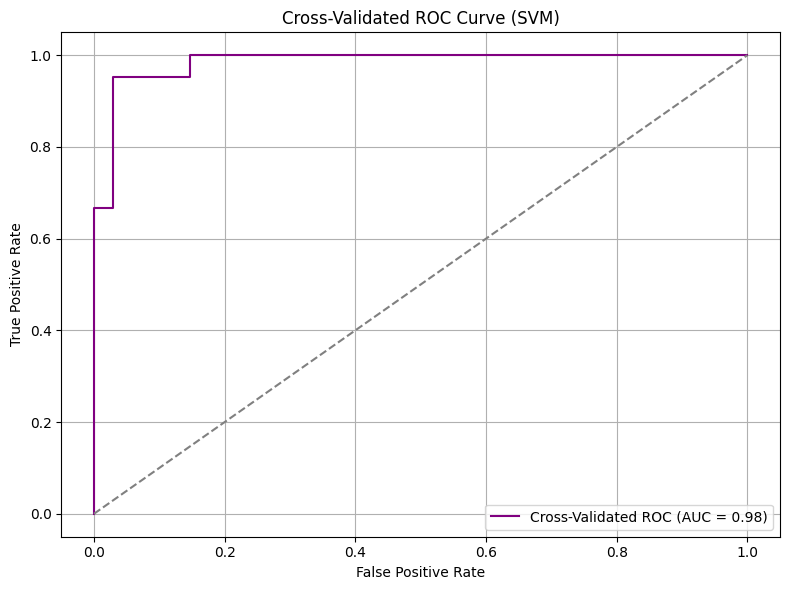

Confusion Matrix:
 [[33  1]
 [ 1 20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.95      0.95      0.95        21

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55


Cross-validated ROC AUC: 0.984593837535014


In [18]:

# Confusion Matrix & Classification Report
conf_matrix_cv = confusion_matrix(df_combined["Alzheimers_Label"], y_cv_pred)
class_report_cv = classification_report(df_combined["Alzheimers_Label"], y_cv_pred)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, label=f"Cross-Validated ROC (AUC = {roc_auc_cv:.2f})", color="purple")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cross-Validated ROC Curve (SVM)")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", conf_matrix_cv)
print("\nClassification Report:\n", class_report_cv)
print("\nCross-validated ROC AUC:", roc_auc_cv)


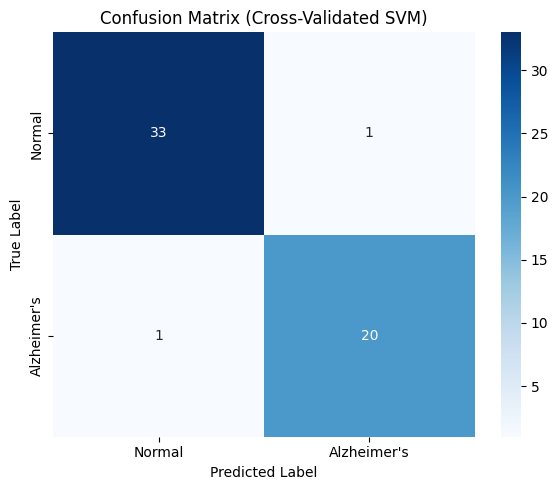

📋 Classification Report (Cross-Validated SVM):

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.95      0.95      0.95        21

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55

📈 ROC-AUC Score: 0.985


In [19]:
# Nicely formatted output for classification report, confusion matrix, and ROC-AUC


# Display confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_cv, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Alzheimer's"], yticklabels=["Normal", "Alzheimer's"])
plt.title("Confusion Matrix (Cross-Validated SVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Print detailed classification report and ROC-AUC
print("📋 Classification Report (Cross-Validated SVM):\n")
print(class_report_cv)
print(f"📈 ROC-AUC Score: {roc_auc_cv:.3f}")

In [20]:
# SVM decision boundary (PCA-2D) on your dataset
# Uses: X_pca (features), df_combined['Alzheimers_Label'] (labels)



# --- 1) Prepare 2D features for plotting ---
X_src = np.asarray(X_pca)
y = np.asarray(df_combined["Alzheimers_Label"])

if X_src.shape[1] > 2:
    pca_vis = PCA(n_components=2, random_state=42)
    X2 = pca_vis.fit_transform(X_src)
else:
    X2 = X_src.copy()

# --- 2) Train SVM on the 2D space ---
svm = SVC(kernel="rbf", C=1.0, gamma="scale")
svm.fit(X2, y)

# --- 3) Create mesh grid for decision regions ---
h = 0.01
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Optional: decision function for zero-margin contour
try:
    ZZ = svm.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
except Exception:
    ZZ = None


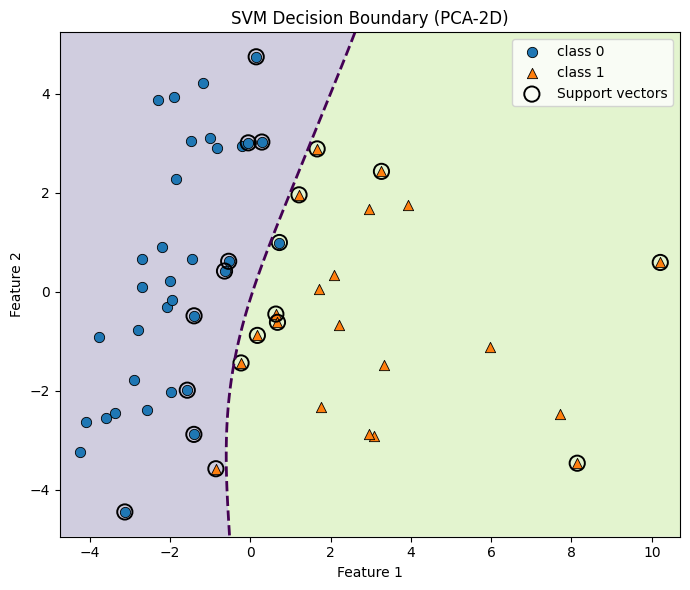

In [21]:

# --- 4) Plot ---
plt.figure(figsize=(7, 6))
# decision regions
plt.contourf(xx, yy, Z, alpha=0.25, levels=np.unique(y).size, antialiased=True)

# decision boundary (margin = 0)
if ZZ is not None:
    plt.contour(xx, yy, ZZ, levels=[0], linewidths=2, linestyles="--")

# data points
classes = np.unique(y)
markers = ["o", "^", "s", "D", "x", "P"]
for i, cls in enumerate(classes):
    idx = (y == cls)
    plt.scatter(X2[idx, 0], X2[idx, 1],
                s=55, marker=markers[i % len(markers)],
                edgecolor="k", linewidth=0.6, label=f"class {cls}")

# support vectors
sv = svm.support_vectors_
plt.scatter(sv[:, 0], sv[:, 1], s=120, facecolors="none",
            edgecolors="k", linewidths=1.4, label="Support vectors")

plt.xlabel("PCA 1" if X_src.shape[1] > 2 else "Feature 1")
plt.ylabel("PCA 2" if X_src.shape[1] > 2 else "Feature 2")
plt.title("SVM Decision Boundary (PCA-2D)")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()


In [22]:
# --- PCA visualization from longitudinal features ---


# 1) Collect all longitudinal feature columns
feature_cols = [c for c in df_combined.columns if c.startswith(("MMSE","CDR","eTIV","nWBV"))]

# 2) Extract feature matrix X and labels y
X_raw = df_combined[feature_cols].dropna().values
y = df_combined.loc[df_combined[feature_cols].dropna().index, "Alzheimers_Label"].values

# 3) Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# 4) PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca_vis = pca.fit_transform(X_scaled)


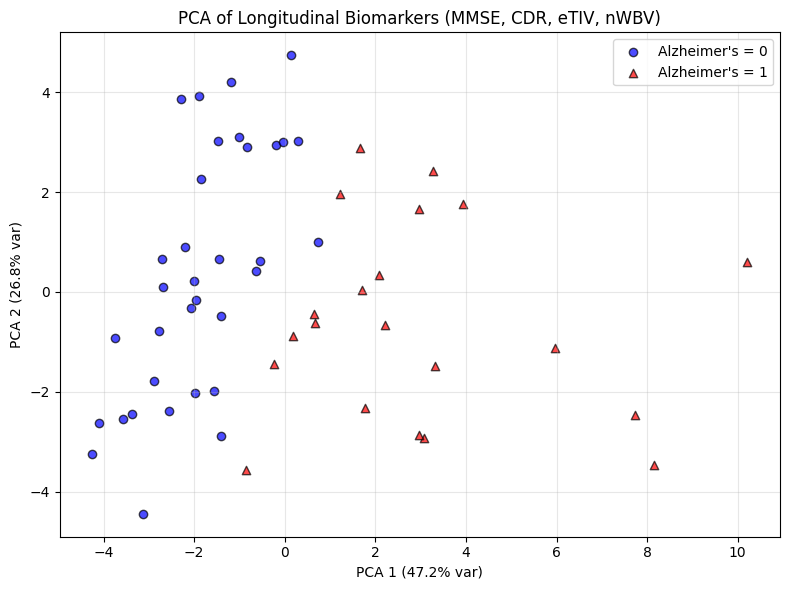

In [23]:

# 5) Scatter plot
plt.figure(figsize=(8,6))
for label, marker, color in [(0, "o", "blue"), (1, "^", "red")]:
    plt.scatter(X_pca_vis[y==label, 0], X_pca_vis[y==label, 1],
                marker=marker, color=color, edgecolor="k",
                alpha=0.7, label=f"Alzheimer's = {label}")
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Longitudinal Biomarkers (MMSE, CDR, eTIV, nWBV)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


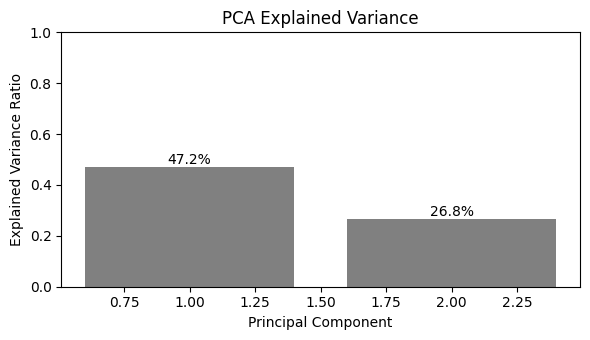

In [24]:

# 6) Explained variance plot
plt.figure(figsize=(6,3.5))
vals = pca.explained_variance_ratio_
xs = np.arange(1, len(vals)+1)
plt.bar(xs, vals, color="gray")
for x, v in zip(xs, vals):
    plt.text(x, v+0.01, f"{v*100:.1f}%", ha="center")
plt.ylim(0, 1)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
plt.tight_layout()
plt.show()
